Merged Lines: 8
Valid Intersections: 5


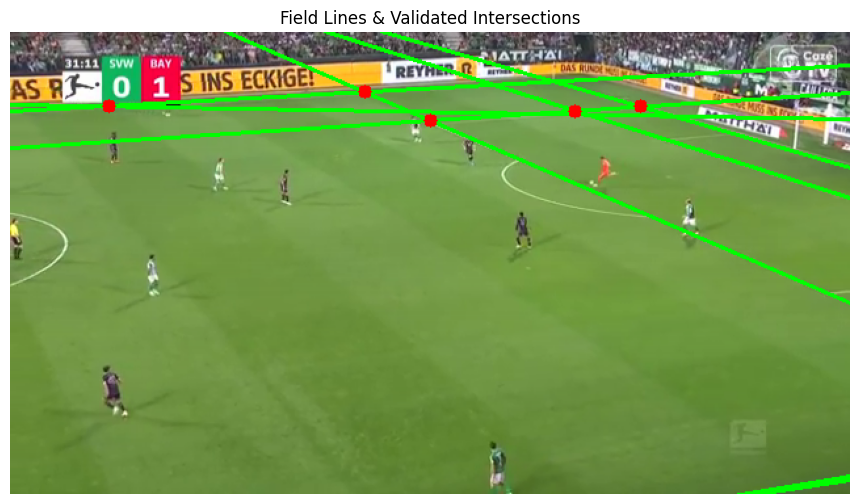

In [ ]:
import cv2
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

######################################
# 1. Green Mask & Refinement
######################################

def get_green_mask(image):
    """
    Convert the image to HSV and threshold for green.
    Adjust the HSV lower/upper bounds for your field.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 50, 50])    # tweak if needed
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    return mask

def refine_mask(mask, open_size=3, close_size=15):
    """
    Use morphological opening to remove small white specks and
    closing to fill small black holes in the mask.
    """
    open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_size, open_size))
    mask_opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, open_kernel)
    close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_size, close_size))
    mask_refined = cv2.morphologyEx(mask_opened, cv2.MORPH_CLOSE, close_kernel)
    return mask_refined

#######################################
# 2. Converting Segments to Lines (A,B,C)
#######################################

def segment_to_abc(x1, y1, x2, y2):
    """
    Convert a finite segment (x1,y1,x2,y2) to a normalized line
    representation A*x + B*y + C = 0 with sqrt(A^2+B^2)=1.
    A consistent sign convention (A>=0) is enforced.
    """
    A = y2 - y1
    B = x1 - x2
    C = x2 * y1 - x1 * y2
    norm = np.sqrt(A * A + B * B)
    if norm < 1e-9:
        return None
    A, B, C = A / norm, B / norm, C / norm
    # Enforce unique sign (A positive or, if A is near zero, then B positive)
    if A < 0 or (abs(A) < 1e-9 and B < 0):
        A, B, C = -A, -B, -C
    return (A, B, C)

####################################################
# 3. Clustering & Merging Similar Lines
####################################################

def angle_between_lines(line1, line2):
    """
    Returns the absolute angle (in degrees) between two normalized lines
    based on their (A,B) parameters.
    """
    A1, B1, _ = line1
    A2, B2, _ = line2
    dot = A1 * A2 + B1 * B2
    dot = np.clip(dot, -1.0, 1.0)
    angle_deg = np.degrees(np.arccos(dot))
    return angle_deg if angle_deg <= 90 else 180 - angle_deg

def offset_difference(line1, line2):
    """
    For lines in normalized form A*x+B*y+C=0, returns |C1 - C2|.
    """
    return abs(line1[2] - line2[2])

def cluster_lines(lines_abc, angle_thresh=3.0, offset_thresh=10.0):
    """
    Group together lines that have a difference in angle less than angle_thresh
    (in degrees) and an offset difference less than offset_thresh.
    Returns a list of clusters (each cluster is a list of indices into lines_abc).
    """
    n = len(lines_abc)
    visited = [False] * n
    clusters = []
    
    def neighbors(idx):
        nbrs = []
        for j in range(n):
            if j != idx and not visited[j]:
                if angle_between_lines(lines_abc[idx], lines_abc[j]) < angle_thresh and \
                   offset_difference(lines_abc[idx], lines_abc[j]) < offset_thresh:
                    nbrs.append(j)
        return nbrs

    def dfs(start):
        stack = [start]
        cluster_idxs = []
        while stack:
            cur = stack.pop()
            if not visited[cur]:
                visited[cur] = True
                cluster_idxs.append(cur)
                stack.extend(neighbors(cur))
        return cluster_idxs

    for i in range(n):
        if not visited[i]:
            cluster = dfs(i)
            clusters.append(cluster)
    return clusters

def fit_line_to_cluster(segments, cluster_indices):
    """
    Given a list of segment indices (from the filtered LSD segments),
    fit a best-fit line through all the endpoints.
    Returns the normalized line (A,B,C).
    """
    points = []
    for idx in cluster_indices:
        x1, y1, x2, y2 = segments[idx]
        points.append((x1, y1))
        points.append((x2, y2))
    if len(points) < 2:
        return None
    pts = np.array(points, dtype=np.float32)
    # Use cv2.fitLine to get (vx,vy,x0,y0) of the line
    line_params = cv2.fitLine(pts, cv2.DIST_L2, param=0, reps=0.01, aeps=0.01)
    vx, vy, x0, y0 = line_params.reshape(-1)
    # Convert to standard form: -vy*x + vx*y + (vy*x0 - vx*y0) = 0.
    A = -vy
    B = vx
    C = (vy * x0 - vx * y0)
    norm = np.sqrt(A * A + B * B)
    if norm < 1e-9:
        return None
    A, B, C = A / norm, B / norm, C / norm
    if A < 0 or (abs(A) < 1e-9 and B < 0):
        A, B, C = -A, -B, -C
    return (A, B, C)

##########################################
# 4. Infinite Line Intersection
##########################################

def intersect_infinite_lines(line1, line2):
    """
    For two normalized lines (A,B,C), compute the intersection point
    of their infinite extensions. Returns (x,y) or None if nearly parallel.
    """
    A1, B1, C1 = line1
    A2, B2, C2 = line2
    det = A1 * B2 - A2 * B1
    if abs(det) < 1e-9:
        return None
    x = (B1 * C2 - B2 * C1) / det
    y = (C1 * A2 - C2 * A1) / det
    return (int(round(x)), int(round(y)))

##########################################
# 5. Intersection Filtering Functions
##########################################

def point_segment_distance(px, py, x1, y1, x2, y2):
    """
    Compute the minimum distance from point (px,py) to the line segment (x1,y1)-(x2,y2).
    """
    seg_len2 = (x2 - x1) ** 2 + (y2 - y1) ** 2
    if seg_len2 < 1e-9:
        return np.hypot(px - x1, py - y1)
    t = ((px - x1) * (x2 - x1) + (py - y1) * (y2 - y1)) / seg_len2
    if t < 0:
        return np.hypot(px - x1, py - y1)
    elif t > 1:
        return np.hypot(px - x2, py - y2)
    projx = x1 + t * (x2 - x1)
    projy = y1 + t * (y2 - y1)
    return np.hypot(px - projx, py - projy)

def is_intersection_near_segments(ix, iy, segments, max_dist=10.0):
    """
    Check if point (ix,iy) is within max_dist of at least one segment in the list.
    """
    for (x1, y1, x2, y2) in segments:
        if point_segment_distance(ix, iy, x1, y1, x2, y2) < max_dist:
            return True
    return False

##########################################
# 6. Main Pipeline Function
##########################################

def detect_field_line_intersections_with_validation(
    image_path,
    min_length=50,
    open_size=3,
    close_size=15,
    angle_thresh=3.0,
    offset_thresh=10.0,
    intersection_max_dist=10.0
):
    """
    Full pipeline:
      1. Load image and build a refined green mask.
      2. Detect LSD line segments and filter them based on length and mask.
      3. Convert segments to normalized lines and cluster them.
      4. Merge each cluster to obtain one representative (merged) line.
      5. Compute infinite-line intersections between merged lines.
      6. Validate each intersection by ensuring it is near at least one original LSD segment
         from each cluster.
      7. Return the final output image with merged lines and validated intersections.
    """
    # Load image and create refined green mask
    image = cv2.imread(image_path)
    if image is None:
        raise IOError(f"Cannot read image: {image_path}")
    mask_green = get_green_mask(image)
    mask_refined = refine_mask(mask_green, open_size=open_size, close_size=close_size)
    
    # Detect LSD segments
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lsd = cv2.createLineSegmentDetector()
    raw_lines = lsd.detect(gray)[0]
    if raw_lines is None:
        return image, [], []
    
    # Filter segments: keep segments with sufficient length and whose midpoint lies on the refined mask.
    segments = []
    for l in raw_lines:
        x1, y1, x2, y2 = map(int, l[0])
        if np.hypot(x2 - x1, y2 - y1) < min_length:
            continue
        midx, midy = (x1 + x2) // 2, (y1 + y2) // 2
        if mask_refined[midy, midx] > 0:
            segments.append((x1, y1, x2, y2))
    
    # Convert each segment to a normalized line (A,B,C)
    lines_abc = []
    for seg in segments:
        line_abc = segment_to_abc(*seg)
        if line_abc is not None:
            lines_abc.append(line_abc)
    
    # Cluster the similar lines
    clusters = cluster_lines(lines_abc, angle_thresh=angle_thresh, offset_thresh=offset_thresh)
    
    # For each cluster, merge segments to one representative line and also keep the original segments.
    merged_lines = []
    cluster_segments = []  # a list of lists, each containing the segments corresponding to the merged line
    for cluster_indices in clusters:
        merged_line = fit_line_to_cluster(segments, cluster_indices)
        if merged_line is not None:
            merged_lines.append(merged_line)
            cluster_segs = [segments[idx] for idx in cluster_indices]
            cluster_segments.append(cluster_segs)
    
    # Compute intersections between every pair of merged lines,
    # but only accept an intersection if it lies near (within intersection_max_dist)
    # at least one original segment from each involved cluster.
    valid_intersections = []
    num = len(merged_lines)
    for i in range(num):
        for j in range(i + 1, num):
            pt = intersect_infinite_lines(merged_lines[i], merged_lines[j])
            if pt is None:
                continue
            ix, iy = pt
            if is_intersection_near_segments(ix, iy, cluster_segments[i], max_dist=intersection_max_dist) and \
               is_intersection_near_segments(ix, iy, cluster_segments[j], max_dist=intersection_max_dist):
                valid_intersections.append(pt)
    
    # Remove duplicate intersections (using rounded coordinates)
    unique_intersections = []
    seen = set()
    for (ix, iy) in valid_intersections:
        key = (round(ix), round(iy))
        if key not in seen:
            seen.add(key)
            unique_intersections.append((ix, iy))
    
    # Draw the merged lines and validated intersections on a copy of the image.
    out = image.copy()
    h, w = out.shape[:2]
    # Draw merged lines in green.
    for (A, B, C) in merged_lines:
        if abs(B) > 1e-9:
            x0, x1 = 0, w
            y0 = int(round(- (A * x0 + C) / B))
            y1 = int(round(- (A * x1 + C) / B))
            cv2.line(out, (x0, y0), (x1, y1), (0, 255, 0), 2)
        else:
            x_val = int(round(-C / A))
            cv2.line(out, (x_val, 0), (x_val, h), (0, 255, 0), 2)
    
    # Draw validated intersection points in red.
    for (ix, iy) in unique_intersections:
        if -50 < ix < w + 50 and -50 < iy < h + 50:
            cv2.circle(out, (ix, iy), 5, (0, 0, 255), -1)
    
    return out, merged_lines, unique_intersections

##########################################
# 7. Run and Visualize the Result
##########################################

if __name__ == "__main__":
    image_path = "data/annotated_homographies/annot_frame_0.png"
    out_img, merged_lines, intersections = detect_field_line_intersections_with_validation(
        image_path,
        min_length=50,      # Only keep segments ≥ 50 pixels long.
        open_size=3,        # Morphological kernel sizes for mask refinement.
        close_size=15,
        angle_thresh=3.0,   # Merge lines if angle difference < 3°.
        offset_thresh=8.0, # Merge lines if offset difference < 10 pixels.
        intersection_max_dist=100.0  # Keep only intersections within 10 pixels of a subline.
    )
    print(f"Merged Lines: {len(merged_lines)}")
    print(f"Valid Intersections: {len(intersections)}")
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
    plt.title("Field Lines & Validated Intersections")
    plt.axis("off")
    plt.show()
